# Bitcoin Price. Prediction by ARIMA

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


### Dataset: https://www.kaggle.com/mczielinski/bitcoin-historical-data

## Data Exploration

In [19]:
# Load data
df = pd.read_csv('C:/Users/HP/Downloads/eth_data_mon.csv')
for i in range(df.shape[0]):
    df['Date'].iloc[i] = int(pd.Timestamp(pd.to_datetime(df['Date'],format= '%Y-%m-%d' ).iloc[i]).timestamp())
df.head()

,Date,Close,Open,High,Low,Vol.,Change %
0,1677628800,1558.96,1604.69,1677.45,1536.31,3.52M,-2.85%
1,1675209600,1604.69,1585.27,1738.87,1464.10,14.07M,1.23%
2,1672531200,1585.27,1195.69,1678.27,1191.67,15.36M,32.58%
3,1669852800,1195.67,1294.40,1348.43,1152.54,11.56M,-7.63%
4,1667260800,1294.41,1572.89,1666.17,1076.29,25.72M,-17.70%


In [3]:
df = pd.read_csv('./BTC.csv')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,Date,High,Low,Open,Close,Volume,Marketcap
0,2013-04-29,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2013-04-30,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,2013-05-01,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,2013-05-02,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,2013-05-03,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [4]:

for i in range(df.shape[0]):
    df['Date'].iloc[i] = int(pd.Timestamp(pd.to_datetime(df['Date'],format= '%Y-%m-%d' ).iloc[i]).timestamp())
df.head()

,Date,High,Low,Open,Close,Volume,Marketcap
0,1367193600,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,1367280000,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,1367366400,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,1367452800,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,1367539200,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [20]:
# Unix-time to 
df.Date = pd.to_datetime(df.Date, unit='s')

# Resampling to daily frequency
df.index = df.Date
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

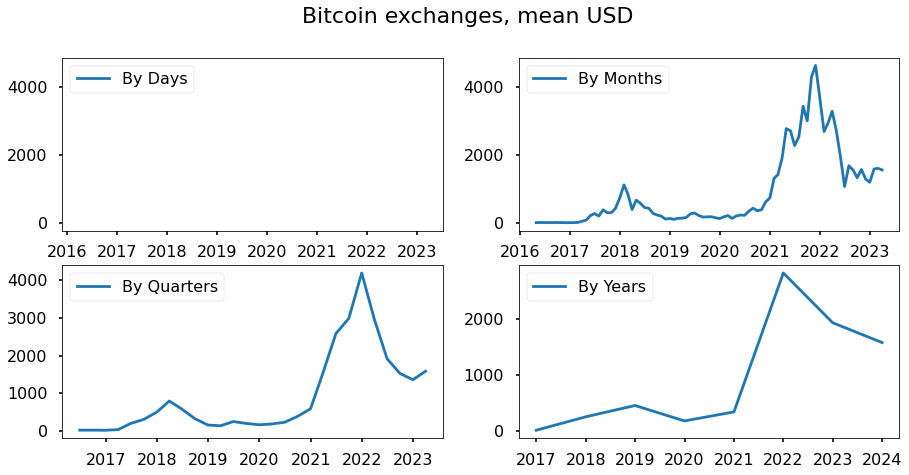

In [21]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Close, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Close, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Close, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Close, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

We will predict bitcoin prices by months.

## Stationarity check and STL-decomposition of the series

Dickey–Fuller test: p=0.646406


<Figure size 1080x504 with 0 Axes>

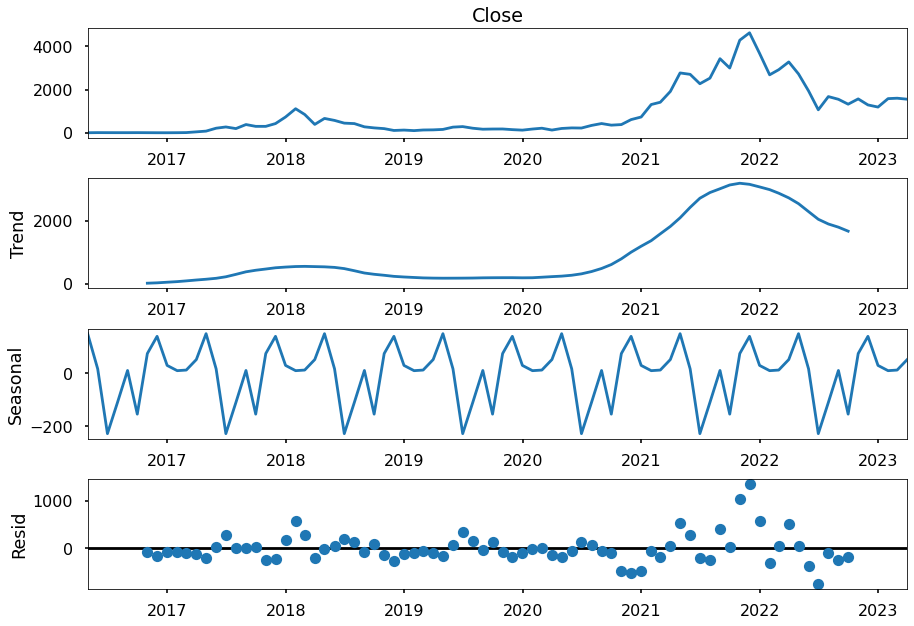

In [22]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Close).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])
plt.show()

The series are not stationary.

## Box-Cox Transformations

In [23]:
# Box-Cox Transformations
df_month['close_box'], lmbda = stats.boxcox(df_month.Close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])

Dickey–Fuller test: p=0.646406


The series are not stationary.

## Seasonal differentiation

In [24]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.close_box - df_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.472281


The series are not stationary.

## Regular differentiation

In [25]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
# plt.figure(figsize=(15,7))

# # STL-decomposition
# sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
# print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

The series are stationary.

## Model Selection

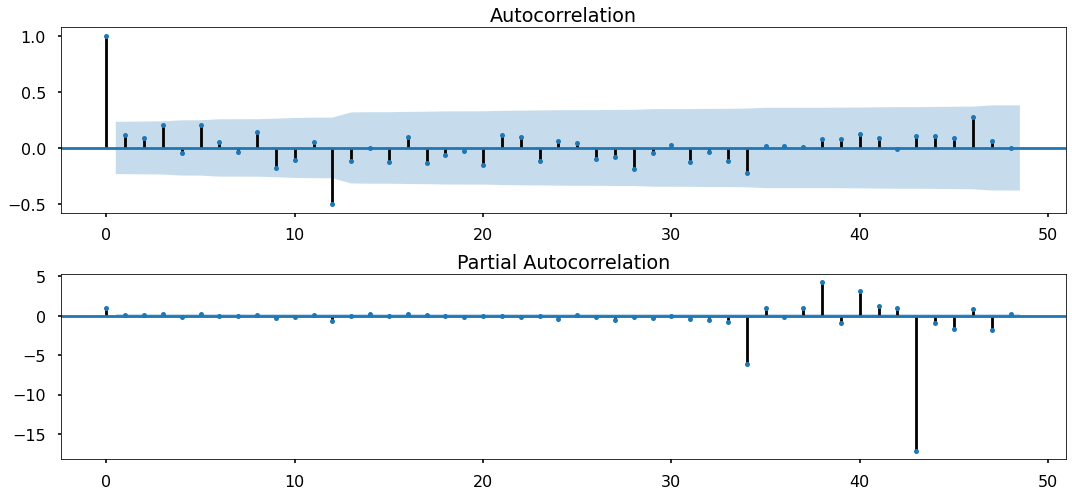

In [26]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [27]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.close_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12), enforce_stationarity=False).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [28]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
22  (1, 0, 2, 0)  129.926265
40  (2, 0, 2, 0)  130.154358
4   (0, 0, 2, 0)  131.197405
23  (1, 0, 2, 1)  131.405615
41  (2, 0, 2, 1)  131.453545
                                     SARIMAX Results                                      
Dep. Variable:                          close_box   No. Observations:                   84
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 -60.963
Date:                            Sun, 19 Mar 2023   AIC                            129.926
Time:                                    10:04:15   BIC                            137.241
Sample:                                04-30-2016   HQIC                           132.666
                                     - 03-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

## Analysis of residues

Dickey–Fuller test:: p=0.107423


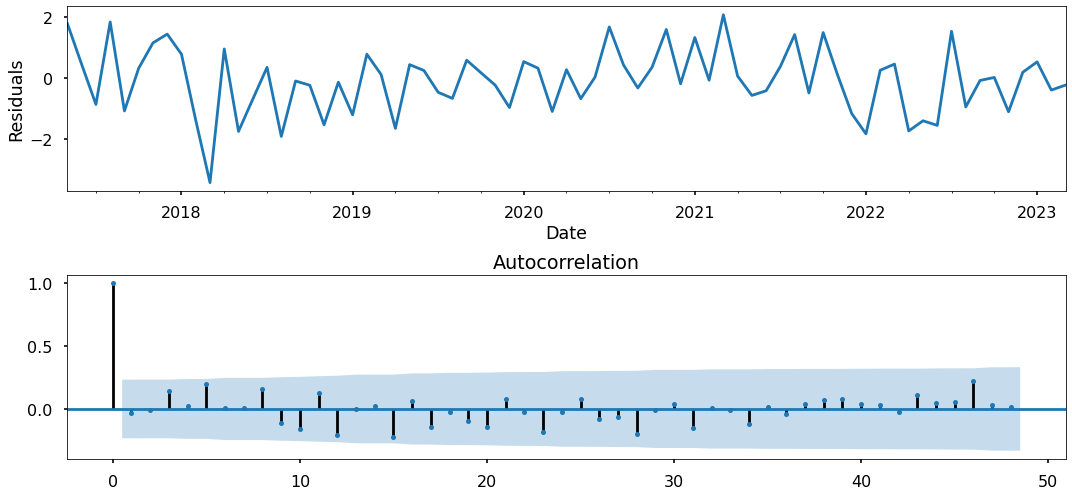

In [29]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

## Prediction

In [30]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

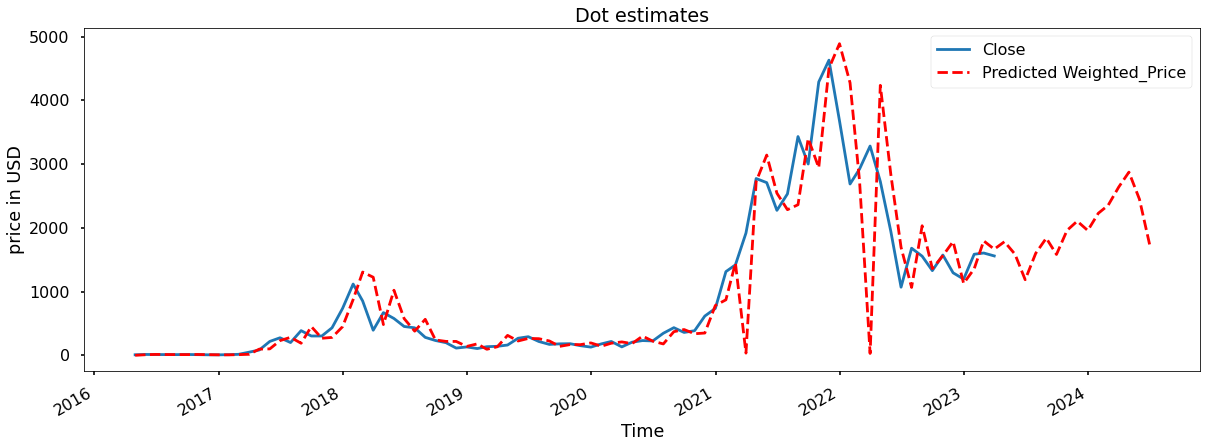

In [31]:
# Prediction
from datetime import datetime
df_month2 = df_month[['Close']]
date_list = [datetime(2023, 3, 31), datetime(2023, 4, 30), datetime(2023, 5, 31), datetime(2023, 6, 30), 
             datetime(2023, 7, 31), datetime(2023, 8, 31), datetime(2023, 9, 30), datetime(2023, 10, 31),
             datetime(2023, 11, 30), datetime(2023, 12, 31), datetime(2024, 1, 31), datetime(2024, 2, 29),
             datetime(2024, 3, 31),datetime(2024, 4, 30),datetime(2024, 5, 31),datetime(2024, 6, 30)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=400), lmbda)


plt.figure(figsize=(20,7))
df_month2.Close.plot()
# df_month2.loc['2022-03-31'] = 30
# df_month2.loc['2021-03-31'] = 35
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Dot estimates')
plt.ylabel('price in USD')
plt.xlabel('Time')
plt.show()

In [32]:
df_month2.forecast.tail(50)

2020-06-30     222.742603
2020-07-31     178.989642
2020-08-31     371.152518
2020-09-30     404.671002
2020-10-31     338.653064
2020-11-30     349.988719
2020-12-31     782.149713
2021-01-31     870.940280
2021-02-28    1447.627986
2021-03-31      35.000000
2021-04-30    2725.499897
2021-05-31    3140.402658
2021-06-30    2542.696853
2021-07-31    2284.315712
2021-08-31    2361.990481
2021-09-30    3400.835813
2021-10-31    2942.534850
2021-11-30    4501.630255
2021-12-31    4886.932163
2022-01-31    4274.709916
2022-02-28    2732.326538
2022-03-31      30.000000
2022-04-30    4234.321121
2022-05-31    2834.478969
2022-06-30    1693.263132
2022-07-31    1064.955404
2022-08-31    2032.159849
2022-09-30    1359.459477
2022-10-31    1563.218594
2022-11-30    1784.314988
2022-12-31    1127.873617
2023-01-31    1356.985431
2023-02-28    1794.737233
2023-03-31    1664.888912
2023-03-31    1664.888912
2023-04-30    1782.021649
2023-05-31    1586.127907
2023-06-30    1185.858482
2023-07-31  

In [33]:
from sklearn import metrics

metrics.mean_squared_error(df_month2.Close, df_month2.forecast)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').